# 07 - Privacy & FedProx Evaluation

**Prerequisite**: Notebook 06 must pass stability calibration first.

This notebook compares **FedAvg vs FedProx** at matched privacy budgets (ε).

## Experiment Matrix

| Algorithm | ε values |
|-----------|----------|
| FedAvg | 200, 150, 120, 100, 80 |
| FedProx (μ=0.1) | 200, 150, 120, 100, 80 |

## Speed Settings

| Setting | Value |
|---------|-------|
| Clients | 5 |
| Local epochs | 2 |
| Rounds | 12 |
| Participation | 80% |
| Batch size | 32 |

## Safety

Single-source heterogeneity enforced: `non_iid_hard` + `uniform` partitioning.

## Metrics

- **MAE vs ε**: Lower is better
- **RMSE vs ε**: Lower is better
- **Stability flag**: STABLE if MAE ≤ 50 and RMSE ≤ 80
- **Collapse threshold**: Lowest ε where training remains stable

In [7]:
# Setup
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
from dataclasses import dataclass
from typing import Optional

from src.utils import set_seed
from experiments.federated_matrix import (
    FederatedExperimentConfig,
    FederatedExperiment,
)

# Styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)

OUTPUT_DIR = Path('../experiments/outputs/privacy_fedprox_eval')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CALIBRATION_DIR = Path('../experiments/outputs/stability_calibration')

print('Setup complete!')
print(f'Output directory: {OUTPUT_DIR}')

Setup complete!
Output directory: ..\experiments\outputs\privacy_fedprox_eval


## 1. Prerequisite Check

In [6]:
# Check that stability calibration passed
verdict_path = CALIBRATION_DIR / 'stability_verdict.json'

if verdict_path.exists():
    with open(verdict_path, 'r') as f:
        verdict = json.load(f)
    
    min_stable_eps = verdict.get('min_stable_epsilon')
    
    if min_stable_eps is not None:
        print(f"[OK] Stability calibration passed.")
        print(f"     Minimum stable ε = {min_stable_eps}")
        
        if min_stable_eps > 50:
            print(f"\n[WARN] min_stable_eps={min_stable_eps} > 50")
            print("       Some experiments may be unstable.")
    else:
        raise RuntimeError(
            "Stability calibration FAILED. Run notebook 06 first."
        )
else:
    print("[WARN] No stability verdict found.")
    print("       Run notebook 06 first for safety.")
    print("       Proceeding anyway (at your own risk)...")
    min_stable_eps = 60  # Assume 60 is safe

[OK] Stability calibration passed.
     Minimum stable ε = 100.0

[WARN] min_stable_eps=100.0 > 50
       Some experiments may be unstable.


## 2. Safety & Configuration

In [5]:
# =============================================================================
# HARD SAFETY RULES - DO NOT MODIFY
# =============================================================================

MAE_THRESHOLD = 50.0
RMSE_THRESHOLD = 80.0

def enforce_single_heterogeneity(config: FederatedExperimentConfig) -> None:
    """Enforce single-source heterogeneity. Raises if violated."""
    
    # Rule 1: Must use non_iid_hard for controlled heterogeneity
    assert config.data_profile == "non_iid_hard", \
        f"Expected data_profile='non_iid_hard', got '{config.data_profile}'"
    
    # Rule 2: Must use uniform partitioning (no Dirichlet stacking)
    assert config.heterogeneity_mode == "uniform", \
        f"Double heterogeneity detected: Dirichlet + non_iid_hard is forbidden. " \
        f"Got heterogeneity_mode='{config.heterogeneity_mode}'"
    
    print("[SAFETY] Single-source heterogeneity verified")


def check_stability(mae: float, rmse: float) -> tuple[bool, str]:
    """Check if metrics indicate stable training."""
    if mae > MAE_THRESHOLD:
        return False, f"MAE={mae:.1f} exceeds threshold {MAE_THRESHOLD}"
    if rmse > RMSE_THRESHOLD:
        return False, f"RMSE={rmse:.1f} exceeds threshold {RMSE_THRESHOLD}"
    return True, "STABLE"


print("Safety functions defined.")
print(f"  • MAE threshold: {MAE_THRESHOLD}")
print(f"  • RMSE threshold: {RMSE_THRESHOLD}")

Safety functions defined.
  • MAE threshold: 50.0
  • RMSE threshold: 80.0


In [4]:
@dataclass
class EvalSpec:
    """Specification for evaluation experiment."""
    name: str
    algorithm: str
    dp_epsilon: float
    fedprox_mu: float


# =============================================================================
# EVALUATION EXPERIMENTS - FedAvg vs FedProx at matched ε
# NEW EPSILON GRID: [200, 150, 120, 100, 80]
# =============================================================================
EPSILONS = [200, 150, 120, 100, 80]
FEDPROX_MU = 0.1  # Stronger regularization for better stability

EVAL_EXPERIMENTS = []

# FedAvg baseline for all ε
for eps in EPSILONS:
    EVAL_EXPERIMENTS.append(EvalSpec(f"FedAvg_{eps}", "fedavg", float(eps), 0.0))

# FedProx comparison for all ε
for eps in EPSILONS:
    EVAL_EXPERIMENTS.append(EvalSpec(f"FedProx_{eps}", "fedprox", float(eps), FEDPROX_MU))

print("Evaluation Experiments:")
print("=" * 65)
print(f"{'Name':<15} | {'Algorithm':<8} | {'ε':<6} | {'μ'}")
print("-" * 65)
for exp in EVAL_EXPERIMENTS:
    print(f"{exp.name:<15} | {exp.algorithm:<8} | {exp.dp_epsilon:<6} | {exp.fedprox_mu}")
print("=" * 65)
print(f"\nTotal: {len(EVAL_EXPERIMENTS)} experiments ({len(EPSILONS)} ε × 2 algorithms)")

Evaluation Experiments:
Name            | Algorithm | ε      | μ
-----------------------------------------------------------------
FedAvg_200      | fedavg   | 200.0  | 0.0
FedAvg_150      | fedavg   | 150.0  | 0.0
FedAvg_120      | fedavg   | 120.0  | 0.0
FedAvg_100      | fedavg   | 100.0  | 0.0
FedAvg_80       | fedavg   | 80.0   | 0.0
FedProx_200     | fedprox  | 200.0  | 0.1
FedProx_150     | fedprox  | 150.0  | 0.1
FedProx_120     | fedprox  | 120.0  | 0.1
FedProx_100     | fedprox  | 100.0  | 0.1
FedProx_80      | fedprox  | 80.0   | 0.1

Total: 10 experiments (5 ε × 2 algorithms)


In [8]:
def create_eval_config(spec: EvalSpec, seed: int = 42) -> FederatedExperimentConfig:
    """Create evaluation config with safety enforcement."""
    
    config = FederatedExperimentConfig(
        experiment_id=spec.name,
        experiment_name=f"fedprox_eval_{spec.name}",
        
        # Data settings - SINGLE-SOURCE HETEROGENEITY
        data_profile="non_iid_hard",
        window_size=50,
        hop_size=10,
        normalize_windows=True,
        global_test_split=0.15,
        
        # ======= SPEED OPTIMIZATIONS (heavier than calibration) =======
        num_clients=5,              # Halves computation
        participation_fraction=0.8, # Higher for better convergence
        local_epochs=2,             # Slightly more training
        num_rounds=12,              # More rounds for comparison
        batch_size=32,              # Better utilization
        # ==============================================================
        
        # BLOCK DIRICHLET EXPLICITLY
        heterogeneity_mode="uniform",
        dirichlet_alpha=0.5,  # Ignored
        
        # Task
        task="rul",
        
        # Model (unchanged)
        num_layers=4,
        hidden_dim=64,
        kernel_size=3,
        dropout=0.2,
        fc_hidden=32,
        
        # Training
        lr=0.001,
        weight_decay=0.0001,
        optimizer="adam",
        early_stopping_enabled=True,
        early_stopping_patience=3,
        normalize_rul=True,
        
        # Algorithm selection
        algorithm=spec.algorithm,
        fedprox_mu=spec.fedprox_mu,
        
        # Privacy settings - ALWAYS ON for evaluation
        enable_dp=True,
        dp_epsilon=spec.dp_epsilon,
        dp_delta=1e-5,
        dp_max_grad_norm=1.0,
        
        # Output
        output_dir=str(OUTPUT_DIR / spec.name),
        save_checkpoints=True,
        eval_every=2,
        checkpoint_every=6,
        
        # Reproducibility
        seed=seed,
        deterministic=True,
    )
    
    # ENFORCE SAFETY
    enforce_single_heterogeneity(config)
    
    return config


# Test config creation
test_config = create_eval_config(EVAL_EXPERIMENTS[0])
print(f"\nConfig validated. Settings:")
print(f"  • Clients: {test_config.num_clients}")
print(f"  • Local epochs: {test_config.local_epochs}")
print(f"  • Rounds: {test_config.num_rounds}")
print(f"  • Participation: {test_config.participation_fraction}")

[SAFETY] Single-source heterogeneity verified

Config validated. Settings:
  • Clients: 5
  • Local epochs: 2
  • Rounds: 12
  • Participation: 0.8


## 3. Run Evaluation Experiments

In [9]:
# Check existing results
existing_results = {}
missing_experiments = []

for spec in EVAL_EXPERIMENTS:
    results_path = OUTPUT_DIR / spec.name / "results.json"
    if results_path.exists():
        with open(results_path, 'r') as f:
            existing_results[spec.name] = json.load(f)
        print(f"[OK] {spec.name}: Results found")
    else:
        missing_experiments.append(spec)
        print(f"[--] {spec.name}: Not yet run")

print(f"\n{len(existing_results)}/{len(EVAL_EXPERIMENTS)} completed.")

[--] FedAvg_200: Not yet run
[--] FedAvg_150: Not yet run
[--] FedAvg_120: Not yet run
[--] FedAvg_100: Not yet run
[--] FedAvg_80: Not yet run
[--] FedProx_200: Not yet run
[--] FedProx_150: Not yet run
[--] FedProx_120: Not yet run
[--] FedProx_100: Not yet run
[--] FedProx_80: Not yet run

0/10 completed.


In [10]:
# Run evaluation experiments
RUN_MISSING = True

experiments_to_run = missing_experiments if RUN_MISSING else []

if experiments_to_run:
    print(f"Running {len(experiments_to_run)} evaluation experiments...")
    print("=" * 60)
    
    for spec in experiments_to_run:
        print(f"\n>>> {spec.name} ({spec.algorithm}, ε={spec.dp_epsilon}, μ={spec.fedprox_mu})")
        
        config = create_eval_config(spec)
        experiment = FederatedExperiment(config)
        
        try:
            results = experiment.run()
            existing_results[spec.name] = results
            
            final_mae = results.get('final_metrics', {}).get('mae', float('nan'))
            final_rmse = results.get('final_metrics', {}).get('rmse', float('nan'))
            
            print(f"    Completed: MAE={final_mae:.2f}, RMSE={final_rmse:.2f}")
            
        except Exception as e:
            print(f"    FAILED: {e}")
            import traceback
            traceback.print_exc()
    
    print("\n" + "=" * 60)
    print("Evaluation complete!")
else:
    print("No experiments to run. Loading existing results.")

2026-01-17 15:48:38,157 [INFO] Using NON-IID HARD data profile
2026-01-17 15:48:38,158 [INFO]   - Label skew: client-specific RUL distributions
2026-01-17 15:48:38,159 [INFO]   - Feature skew: client-specific noise/bias
2026-01-17 15:48:38,161 [INFO]   - Quantity skew: imbalanced sample counts


Running 10 evaluation experiments...

>>> FedAvg_200 (fedavg, ε=200.0, μ=0.0)
[SAFETY] Single-source heterogeneity verified


2026-01-17 15:48:38,726 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:48:38,736 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:48:38,737 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:48:38,739 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:48:38,741 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:48:38,754 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:48:38,755 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:48:38,766 [INFO] ============================================================
2026-01-17 15:48:38,768 [INFO] Starting Federated Training: FedAvg_200
2026-01-17 15:48:38,769 [INFO]   Algorithm: FEDAVG
2026-01-17 15:48:38,770 [INFO]   Rounds: 12
2026-01-17 15:48:38,772 [INFO]   Clients: 5
2026-01-17 15:48:38,773 [INFO]   Participation: 80%
2026-01-17 15:48:38,775 [INFO]   Local epochs: 2
2026-01-17 15:48:38,776 [INFO]   Heterogeneity: uniform
2026-01-17 15:48:38,777 [INFO

    Completed: MAE=29.10, RMSE=42.32

>>> FedAvg_150 (fedavg, ε=150.0, μ=0.0)
[SAFETY] Single-source heterogeneity verified


2026-01-17 15:50:52,661 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:50:52,671 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:50:52,674 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:50:52,677 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:50:52,680 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:50:52,682 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:50:52,685 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:50:52,697 [INFO] ============================================================
2026-01-17 15:50:52,699 [INFO] Starting Federated Training: FedAvg_150
2026-01-17 15:50:52,700 [INFO]   Algorithm: FEDAVG
2026-01-17 15:50:52,704 [INFO]   Rounds: 12
2026-01-17 15:50:52,706 [INFO]   Clients: 5
2026-01-17 15:50:52,708 [INFO]   Participation: 80%
2026-01-17 15:50:52,710 [INFO]   Local epochs: 2
2026-01-17 15:50:52,713 [INFO]   Heterogeneity: uniform
2026-01-17 15:50:52,715 [INFO

    Completed: MAE=39.83, RMSE=65.66

>>> FedAvg_120 (fedavg, ε=120.0, μ=0.0)
[SAFETY] Single-source heterogeneity verified


2026-01-17 15:53:22,581 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:53:22,587 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:53:22,590 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:53:22,592 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:53:22,594 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:53:22,595 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:53:22,597 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:53:22,611 [INFO] ============================================================
2026-01-17 15:53:22,614 [INFO] Starting Federated Training: FedAvg_120
2026-01-17 15:53:22,616 [INFO]   Algorithm: FEDAVG
2026-01-17 15:53:22,619 [INFO]   Rounds: 12
2026-01-17 15:53:22,620 [INFO]   Clients: 5
2026-01-17 15:53:22,623 [INFO]   Participation: 80%
2026-01-17 15:53:22,625 [INFO]   Local epochs: 2
2026-01-17 15:53:22,627 [INFO]   Heterogeneity: uniform
2026-01-17 15:53:22,630 [INFO

    Completed: MAE=65.58, RMSE=98.46

>>> FedAvg_100 (fedavg, ε=100.0, μ=0.0)
[SAFETY] Single-source heterogeneity verified


2026-01-17 15:55:10,929 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:55:10,936 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:55:10,938 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:55:10,940 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:55:10,943 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:55:10,945 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:55:10,947 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:55:10,960 [INFO] ============================================================
2026-01-17 15:55:10,963 [INFO] Starting Federated Training: FedAvg_100
2026-01-17 15:55:10,965 [INFO]   Algorithm: FEDAVG
2026-01-17 15:55:10,966 [INFO]   Rounds: 12
2026-01-17 15:55:10,968 [INFO]   Clients: 5
2026-01-17 15:55:10,970 [INFO]   Participation: 80%
2026-01-17 15:55:10,974 [INFO]   Local epochs: 2
2026-01-17 15:55:10,976 [INFO]   Heterogeneity: uniform
2026-01-17 15:55:10,977 [INFO

    Completed: MAE=82.76, RMSE=140.45

>>> FedAvg_80 (fedavg, ε=80.0, μ=0.0)
[SAFETY] Single-source heterogeneity verified


2026-01-17 15:56:37,699 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:56:37,706 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:56:37,707 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:56:37,709 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:56:37,710 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:56:37,711 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:56:37,712 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:56:37,721 [INFO] ============================================================
2026-01-17 15:56:37,722 [INFO] Starting Federated Training: FedAvg_80
2026-01-17 15:56:37,723 [INFO]   Algorithm: FEDAVG
2026-01-17 15:56:37,725 [INFO]   Rounds: 12
2026-01-17 15:56:37,727 [INFO]   Clients: 5
2026-01-17 15:56:37,729 [INFO]   Participation: 80%
2026-01-17 15:56:37,731 [INFO]   Local epochs: 2
2026-01-17 15:56:37,733 [INFO]   Heterogeneity: uniform
2026-01-17 15:56:37,734 [INFO]

    Completed: MAE=142.44, RMSE=226.88

>>> FedProx_200 (fedprox, ε=200.0, μ=0.1)
[SAFETY] Single-source heterogeneity verified


2026-01-17 15:58:08,501 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:58:08,509 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:58:08,511 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:58:08,513 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:58:08,514 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:58:08,516 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:58:08,519 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:58:08,532 [INFO] ============================================================
2026-01-17 15:58:08,534 [INFO] Starting Federated Training: FedProx_200
2026-01-17 15:58:08,535 [INFO]   Algorithm: FEDPROX
2026-01-17 15:58:08,536 [INFO]   FedProx mu: 0.1
2026-01-17 15:58:08,540 [INFO]   Rounds: 12
2026-01-17 15:58:08,542 [INFO]   Clients: 5
2026-01-17 15:58:08,546 [INFO]   Participation: 80%
2026-01-17 15:58:08,548 [INFO]   Local epochs: 2
2026-01-17 15:58:08,549 [INFO]   H

    Completed: MAE=32.59, RMSE=49.19

>>> FedProx_150 (fedprox, ε=150.0, μ=0.1)
[SAFETY] Single-source heterogeneity verified


2026-01-17 15:59:45,818 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:59:45,832 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:59:45,836 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:59:45,838 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:59:45,841 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:59:45,843 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:59:45,846 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:59:45,866 [INFO] ============================================================
2026-01-17 15:59:45,868 [INFO] Starting Federated Training: FedProx_150
2026-01-17 15:59:45,870 [INFO]   Algorithm: FEDPROX
2026-01-17 15:59:45,871 [INFO]   FedProx mu: 0.1
2026-01-17 15:59:45,873 [INFO]   Rounds: 12
2026-01-17 15:59:45,874 [INFO]   Clients: 5
2026-01-17 15:59:45,877 [INFO]   Participation: 80%
2026-01-17 15:59:45,880 [INFO]   Local epochs: 2
2026-01-17 15:59:45,881 [INFO]   H

    Completed: MAE=53.12, RMSE=77.18

>>> FedProx_120 (fedprox, ε=120.0, μ=0.1)
[SAFETY] Single-source heterogeneity verified


2026-01-17 16:01:48,646 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 16:01:48,650 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 16:01:48,652 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 16:01:48,653 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 16:01:48,653 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 16:01:48,654 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 16:01:48,655 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 16:01:48,667 [INFO] ============================================================
2026-01-17 16:01:48,669 [INFO] Starting Federated Training: FedProx_120
2026-01-17 16:01:48,673 [INFO]   Algorithm: FEDPROX
2026-01-17 16:01:48,675 [INFO]   FedProx mu: 0.1
2026-01-17 16:01:48,676 [INFO]   Rounds: 12
2026-01-17 16:01:48,679 [INFO]   Clients: 5
2026-01-17 16:01:48,680 [INFO]   Participation: 80%
2026-01-17 16:01:48,682 [INFO]   Local epochs: 2
2026-01-17 16:01:48,684 [INFO]   H

    Completed: MAE=75.60, RMSE=109.41

>>> FedProx_100 (fedprox, ε=100.0, μ=0.1)
[SAFETY] Single-source heterogeneity verified


2026-01-17 16:02:57,048 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 16:02:57,054 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 16:02:57,055 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 16:02:57,056 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 16:02:57,058 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 16:02:57,060 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 16:02:57,061 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 16:02:57,069 [INFO] ============================================================
2026-01-17 16:02:57,070 [INFO] Starting Federated Training: FedProx_100
2026-01-17 16:02:57,071 [INFO]   Algorithm: FEDPROX
2026-01-17 16:02:57,071 [INFO]   FedProx mu: 0.1
2026-01-17 16:02:57,073 [INFO]   Rounds: 12
2026-01-17 16:02:57,074 [INFO]   Clients: 5
2026-01-17 16:02:57,075 [INFO]   Participation: 80%
2026-01-17 16:02:57,076 [INFO]   Local epochs: 2
2026-01-17 16:02:57,077 [INFO]   H

    Completed: MAE=113.75, RMSE=174.90

>>> FedProx_80 (fedprox, ε=80.0, μ=0.1)
[SAFETY] Single-source heterogeneity verified


2026-01-17 16:04:04,890 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 16:04:04,895 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 16:04:04,896 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 16:04:04,897 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 16:04:04,897 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 16:04:04,900 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 16:04:04,901 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 16:04:04,909 [INFO] ============================================================
2026-01-17 16:04:04,910 [INFO] Starting Federated Training: FedProx_80
2026-01-17 16:04:04,911 [INFO]   Algorithm: FEDPROX
2026-01-17 16:04:04,912 [INFO]   FedProx mu: 0.1
2026-01-17 16:04:04,913 [INFO]   Rounds: 12
2026-01-17 16:04:04,914 [INFO]   Clients: 5
2026-01-17 16:04:04,915 [INFO]   Participation: 80%
2026-01-17 16:04:04,916 [INFO]   Local epochs: 2
2026-01-17 16:04:04,917 [INFO]   He

    Completed: MAE=142.25, RMSE=256.68

Evaluation complete!


## 4. Results Analysis

In [11]:
# Reload all results
all_results = {}

for spec in EVAL_EXPERIMENTS:
    results_path = OUTPUT_DIR / spec.name / "results.json"
    if results_path.exists():
        with open(results_path, 'r') as f:
            all_results[spec.name] = json.load(f)

# Create summary with stability flags
summary_data = []
for spec in EVAL_EXPERIMENTS:
    if spec.name not in all_results:
        continue
    result = all_results[spec.name]
    final_metrics = result.get('final_metrics', {})
    
    mae = final_metrics.get('mae', np.nan)
    rmse = final_metrics.get('rmse', np.nan)
    stable, status = check_stability(mae, rmse) if not np.isnan(mae) else (False, "NO DATA")
    
    summary_data.append({
        'name': spec.name,
        'algorithm': spec.algorithm.upper(),
        'epsilon': spec.dp_epsilon,
        'mu': spec.fedprox_mu,
        'final_mae': mae,
        'final_rmse': rmse,
        'best_loss': result.get('best_loss', np.nan),
        'best_round': result.get('best_round', np.nan),
        'stable': stable,
        'status': status,
    })

df_summary = pd.DataFrame(summary_data)

if len(df_summary) > 0:
    print("EVALUATION RESULTS")
    print("=" * 90)
    display(df_summary.round(2))
else:
    print("No results yet. Run experiments first.")
    # Simulated data for visualization
    np.random.seed(42)
    summary_data = []
    for exp in EVAL_EXPERIMENTS:
        noise = 30.0 / exp.dp_epsilon
        mu_benefit = 3.0 if exp.algorithm == 'fedprox' else 0.0
        mae = 12.0 + noise * 10 - mu_benefit + np.random.randn() * 2
        rmse = mae * 1.3 + np.random.randn() * 2
        stable, status = check_stability(mae, rmse)
        summary_data.append({
            'name': exp.name, 'algorithm': exp.algorithm.upper(), 'epsilon': exp.dp_epsilon,
            'mu': exp.fedprox_mu, 'final_mae': mae, 'final_rmse': rmse,
            'best_loss': 0.1 + noise * 0.05, 'best_round': 10 - int(noise),
            'stable': stable, 'status': status,
        })
    df_summary = pd.DataFrame(summary_data)
    print("(Simulated data for visualization)")
    display(df_summary.round(2))

EVALUATION RESULTS


,name,algorithm,epsilon,mu,final_mae,final_rmse,best_loss,best_round,stable,status
0,FedAvg_200,FEDAVG,200.0,0.0,29.10,42.32,0.08,4,True,STABLE
1,FedAvg_150,FEDAVG,150.0,0.0,39.83,65.66,0.07,4,True,STABLE
2,FedAvg_120,FEDAVG,120.0,0.0,65.58,98.46,0.08,4,False,MAE=65.6 exceeds threshold 50.0
3,FedAvg_100,FEDAVG,100.0,0.0,82.76,140.45,0.09,2,False,MAE=82.8 exceeds threshold 50.0
4,FedAvg_80,FEDAVG,80.0,0.0,142.44,226.88,0.09,2,False,MAE=142.4 exceeds threshold 50.0
5,FedProx_200,FEDPROX,200.0,0.1,32.59,49.19,0.07,4,True,STABLE
6,FedProx_150,FEDPROX,150.0,0.1,53.12,77.18,0.07,4,False,MAE=53.1 exceeds threshold 50.0
7,FedProx_120,FEDPROX,120.0,0.1,75.60,109.41,0.09,4,False,MAE=75.6 exceeds threshold 50.0
8,FedProx_100,FEDPROX,100.0,0.1,113.75,174.90,0.17,2,False,MAE=113.8 exceeds threshold 50.0
9,FedProx_80,FEDPROX,80.0,0.1,142.25,256.68,0.18,2,False,MAE=142.2 exceeds threshold 50.0


In [12]:
# Calculate FedProx improvement and collapse thresholds at each epsilon
improvements = []

for eps in EPSILONS:
    fedavg = df_summary[(df_summary['algorithm'] == 'FEDAVG') & (df_summary['epsilon'] == eps)]
    fedprox = df_summary[(df_summary['algorithm'] == 'FEDPROX') & (df_summary['epsilon'] == eps)]
    
    if len(fedavg) > 0 and len(fedprox) > 0:
        fa_mae = fedavg['final_mae'].values[0]
        fa_rmse = fedavg['final_rmse'].values[0]
        fa_stable = fedavg['stable'].values[0]
        
        fp_mae = fedprox['final_mae'].values[0]
        fp_rmse = fedprox['final_rmse'].values[0]
        fp_stable = fedprox['stable'].values[0]
        
        mae_improvement = (fa_mae - fp_mae) / fa_mae * 100 if fa_mae > 0 else 0
        rmse_improvement = (fa_rmse - fp_rmse) / fa_rmse * 100 if fa_rmse > 0 else 0
        
        improvements.append({
            'epsilon': eps,
            'fedavg_mae': fa_mae,
            'fedavg_rmse': fa_rmse,
            'fedavg_stable': fa_stable,
            'fedprox_mae': fp_mae,
            'fedprox_rmse': fp_rmse,
            'fedprox_stable': fp_stable,
            'mae_improvement_pct': mae_improvement,
            'rmse_improvement_pct': rmse_improvement,
            'fedprox_better': fp_mae < fa_mae,
        })

df_improvements = pd.DataFrame(improvements)
print("\nFedProx vs FedAvg Comparison:")
print("=" * 80)
display(df_improvements.round(2))

# Find collapse thresholds
print("\n" + "=" * 80)
print("COLLAPSE THRESHOLD ANALYSIS")
print("=" * 80)

fedavg_collapse = None
fedprox_collapse = None

for _, row in df_improvements.sort_values('epsilon').iterrows():
    if not row['fedavg_stable'] and fedavg_collapse is None:
        fedavg_collapse = row['epsilon']
    if not row['fedprox_stable'] and fedprox_collapse is None:
        fedprox_collapse = row['epsilon']

# Report minimum stable ε (last ε where stable)
fedavg_min_stable = df_improvements[df_improvements['fedavg_stable']]['epsilon'].min() if any(df_improvements['fedavg_stable']) else None
fedprox_min_stable = df_improvements[df_improvements['fedprox_stable']]['epsilon'].min() if any(df_improvements['fedprox_stable']) else None

print(f"\n  FedAvg:")
print(f"    • Min stable ε: {fedavg_min_stable if fedavg_min_stable else 'NONE (all unstable)'}")
print(f"    • Collapse below: {fedavg_collapse if fedavg_collapse else 'N/A (stable at all ε)'}")

print(f"\n  FedProx (μ={FEDPROX_MU}):")
print(f"    • Min stable ε: {fedprox_min_stable if fedprox_min_stable else 'NONE (all unstable)'}")
print(f"    • Collapse below: {fedprox_collapse if fedprox_collapse else 'N/A (stable at all ε)'}")

if fedprox_min_stable and fedavg_min_stable:
    shift = fedavg_min_stable - fedprox_min_stable
    if shift > 0:
        print(f"\n  >>> FedProx EXTENDS stable range by Δε = {shift}")
    elif shift < 0:
        print(f"\n  >>> FedAvg more stable by Δε = {-shift}")
    else:
        print(f"\n  >>> Same collapse threshold")


FedProx vs FedAvg Comparison:


,epsilon,fedavg_mae,fedavg_rmse,fedavg_stable,fedprox_mae,fedprox_rmse,fedprox_stable,mae_improvement_pct,rmse_improvement_pct,fedprox_better
0,200,29.10,42.32,True,32.59,49.19,True,-11.97,-16.23,False
1,150,39.83,65.66,True,53.12,77.18,False,-33.39,-17.55,False
2,120,65.58,98.46,False,75.60,109.41,False,-15.29,-11.13,False
3,100,82.76,140.45,False,113.75,174.90,False,-37.46,-24.52,False
4,80,142.44,226.88,False,142.25,256.68,False,0.13,-13.13,True



COLLAPSE THRESHOLD ANALYSIS

  FedAvg:
    • Min stable ε: 150
    • Collapse below: 80

  FedProx (μ=0.1):
    • Min stable ε: 200
    • Collapse below: 80

  >>> FedAvg more stable by Δε = 50


## 5. Visualization

C:\Users\Atharva Srivastava\AppData\Local\Temp\ipykernel_55132\2760290052.py:105: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Atharva Srivastava\AppData\Local\Temp\ipykernel_55132\2760290052.py:105: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Atharva Srivastava\AppData\Local\Temp\ipykernel_55132\2760290052.py:105: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Atharva Srivastava\AppData\Local\Temp\ipykernel_55132\2760290052.py:106: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(OUTPUT_DIR / 'fedavg_vs_fedprox_evaluation.png', dpi=150, bbox_inches='tight')
C:\Users\Atharva Srivastava\AppData\Local\Temp\ipykernel_55132\2760290052.py:106: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.savefig(OUTPUT_DIR / 'fedavg_vs_fedprox_evaluation.png', dpi=150, bbox_inches='tigh

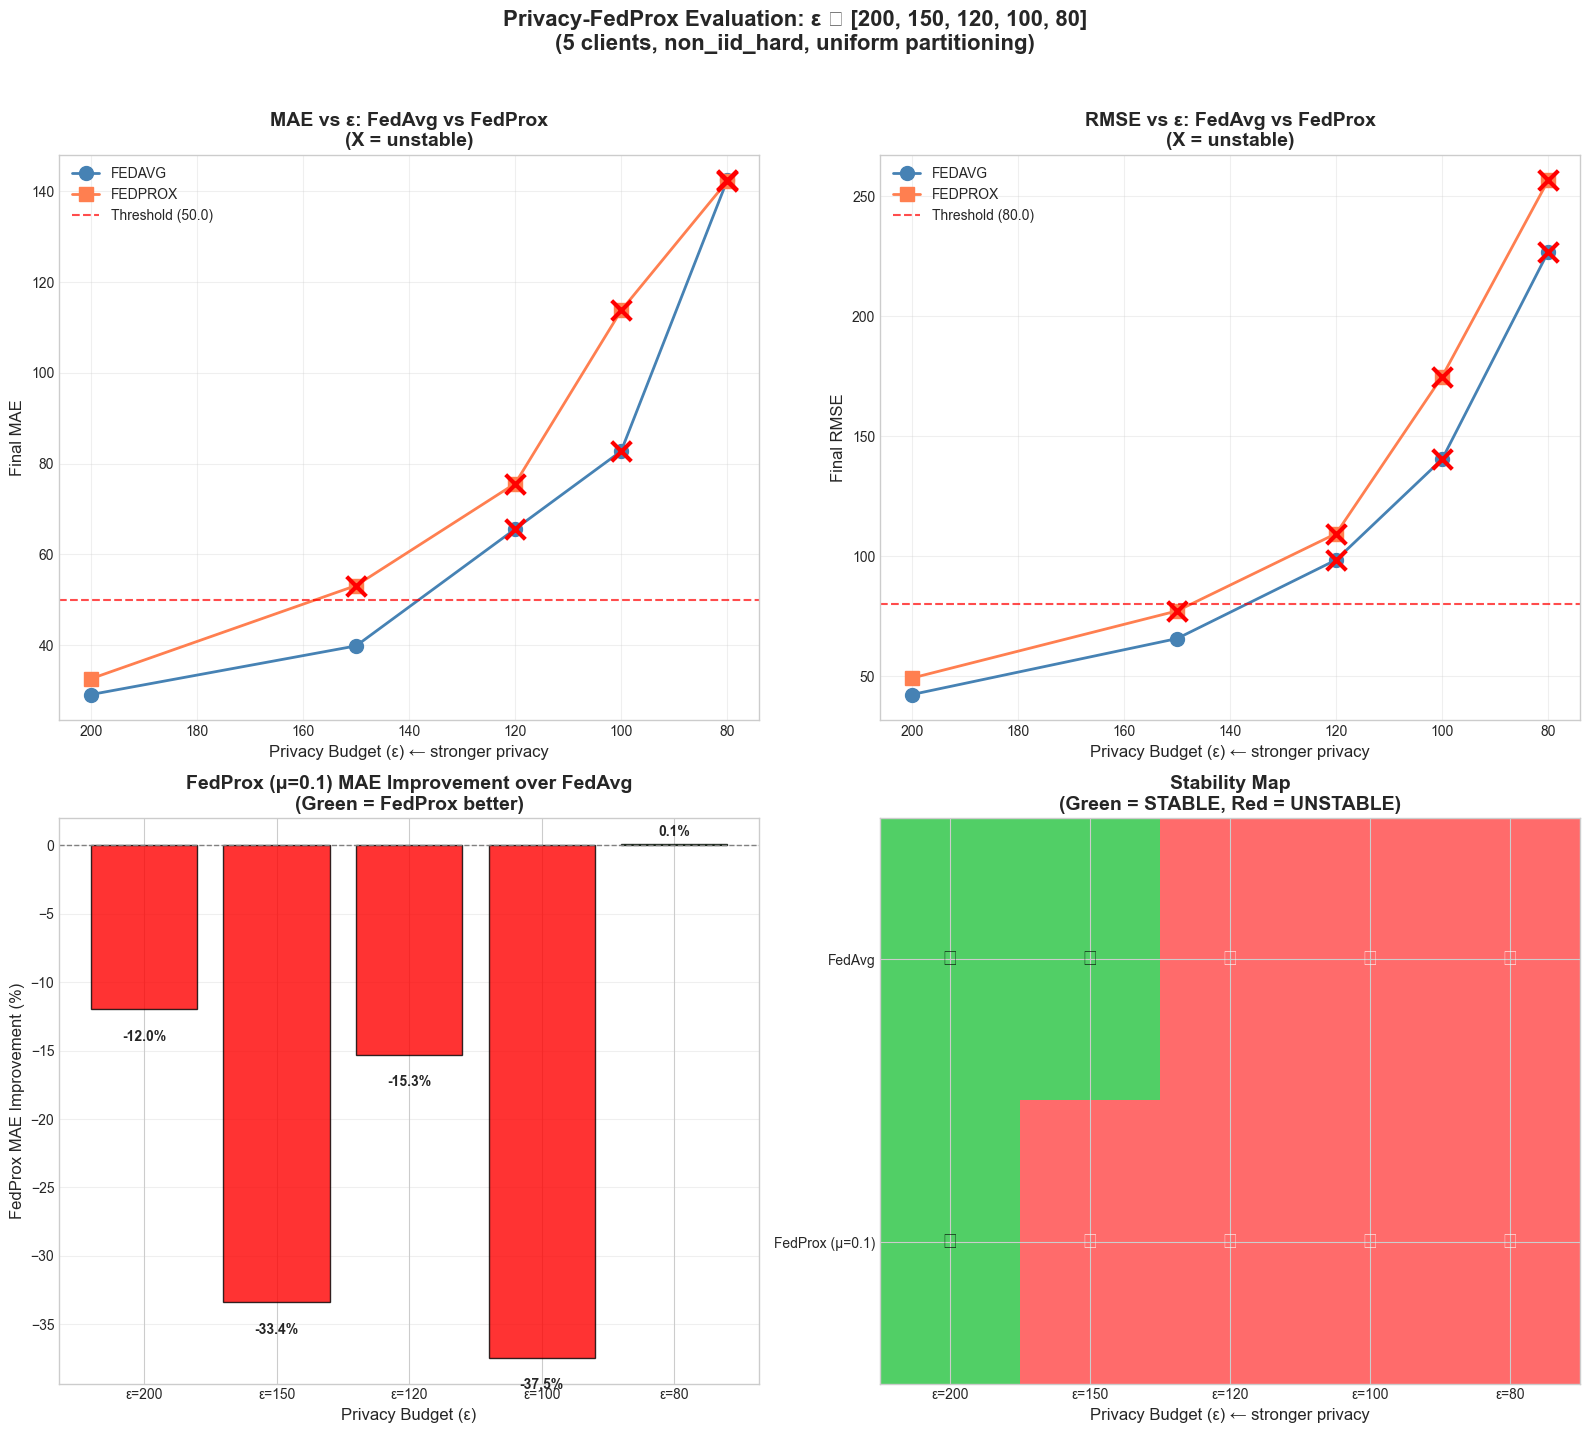


Saved: ..\experiments\outputs\privacy_fedprox_eval\fedavg_vs_fedprox_evaluation.png


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

colors = {'FEDAVG': 'steelblue', 'FEDPROX': 'coral'}
markers = {'FEDAVG': 'o', 'FEDPROX': 's'}

# ----- 1. MAE vs Epsilon -----
ax = axes[0, 0]
for algo in ['FEDAVG', 'FEDPROX']:
    df_algo = df_summary[df_summary['algorithm'] == algo].sort_values('epsilon', ascending=False)
    if len(df_algo) > 0:
        # Plot stable and unstable separately
        stable = df_algo[df_algo['stable']]
        unstable = df_algo[~df_algo['stable']]
        
        ax.plot(df_algo['epsilon'], df_algo['final_mae'], 
                marker=markers[algo], color=colors[algo], 
                linewidth=2, markersize=10, label=algo)
        
        # Mark unstable points with X
        if len(unstable) > 0:
            ax.scatter(unstable['epsilon'], unstable['final_mae'], 
                      marker='x', s=200, c='red', linewidths=3, zorder=5)

ax.axhline(y=MAE_THRESHOLD, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Threshold ({MAE_THRESHOLD})')
ax.set_xlabel('Privacy Budget (ε) ← stronger privacy', fontsize=12)
ax.set_ylabel('Final MAE', fontsize=12)
ax.set_title('MAE vs ε: FedAvg vs FedProx\n(X = unstable)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# ----- 2. RMSE vs Epsilon -----
ax = axes[0, 1]
for algo in ['FEDAVG', 'FEDPROX']:
    df_algo = df_summary[df_summary['algorithm'] == algo].sort_values('epsilon', ascending=False)
    if len(df_algo) > 0:
        ax.plot(df_algo['epsilon'], df_algo['final_rmse'], 
                marker=markers[algo], color=colors[algo], 
                linewidth=2, markersize=10, label=algo)
        
        # Mark unstable points
        unstable = df_algo[~df_algo['stable']]
        if len(unstable) > 0:
            ax.scatter(unstable['epsilon'], unstable['final_rmse'], 
                      marker='x', s=200, c='red', linewidths=3, zorder=5)

ax.axhline(y=RMSE_THRESHOLD, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Threshold ({RMSE_THRESHOLD})')
ax.set_xlabel('Privacy Budget (ε) ← stronger privacy', fontsize=12)
ax.set_ylabel('Final RMSE', fontsize=12)
ax.set_title('RMSE vs ε: FedAvg vs FedProx\n(X = unstable)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# ----- 3. FedProx Improvement Bar Chart (MAE) -----
ax = axes[1, 0]
if len(df_improvements) > 0:
    x = np.arange(len(df_improvements))
    colors_bar = ['green' if imp > 0 else 'red' for imp in df_improvements['mae_improvement_pct']]
    bars = ax.bar(x, df_improvements['mae_improvement_pct'], color=colors_bar, edgecolor='black', alpha=0.8)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    
    for i, (bar, imp) in enumerate(zip(bars, df_improvements['mae_improvement_pct'])):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3 if imp > 0 else bar.get_height() - 1.5,
                f'{imp:.1f}%', ha='center', va='bottom' if imp > 0 else 'top', fontsize=10, fontweight='bold')
    
    ax.set_xticks(x)
    ax.set_xticklabels([f'ε={e}' for e in df_improvements['epsilon']])
    ax.set_xlabel('Privacy Budget (ε)', fontsize=12)
    ax.set_ylabel('FedProx MAE Improvement (%)', fontsize=12)
    ax.set_title(f'FedProx (μ={FEDPROX_MU}) MAE Improvement over FedAvg\n(Green = FedProx better)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# ----- 4. Stability Comparison (Heatmap style) -----
ax = axes[1, 1]
eps_sorted = sorted(EPSILONS, reverse=True)
stability_matrix = np.zeros((2, len(eps_sorted)))

for i, eps in enumerate(eps_sorted):
    row = df_improvements[df_improvements['epsilon'] == eps]
    if len(row) > 0:
        stability_matrix[0, i] = 1 if row['fedavg_stable'].values[0] else 0
        stability_matrix[1, i] = 1 if row['fedprox_stable'].values[0] else 0

cmap = plt.cm.colors.ListedColormap(['#ff6b6b', '#51cf66'])
im = ax.imshow(stability_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=1)

ax.set_xticks(np.arange(len(eps_sorted)))
ax.set_xticklabels([f'ε={e}' for e in eps_sorted])
ax.set_yticks([0, 1])
ax.set_yticklabels(['FedAvg', f'FedProx (μ={FEDPROX_MU})'])

# Add text annotations
for i in range(2):
    for j in range(len(eps_sorted)):
        status = "✓" if stability_matrix[i, j] == 1 else "✗"
        ax.text(j, i, status, ha='center', va='center', fontsize=16, fontweight='bold',
                color='white' if stability_matrix[i, j] == 0 else 'black')

ax.set_title('Stability Map\n(Green = STABLE, Red = UNSTABLE)', fontsize=14, fontweight='bold')
ax.set_xlabel('Privacy Budget (ε) ← stronger privacy', fontsize=12)

fig.suptitle(f'Privacy-FedProx Evaluation: ε ∈ {EPSILONS}\n(5 clients, non_iid_hard, uniform partitioning)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fedavg_vs_fedprox_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {OUTPUT_DIR / 'fedavg_vs_fedprox_evaluation.png'}")

## 6. Convergence Curves

In [15]:
# Load round-level metrics
round_data = {}

for spec in EVAL_EXPERIMENTS:
    round_path = OUTPUT_DIR / spec.name / "round_metrics.csv"
    if round_path.exists():
        round_data[spec.name] = pd.read_csv(round_path)
        print(f"[OK] Loaded: {spec.name}")
    else:
        print(f"[--] No round metrics: {spec.name}")

# Simulate if no data
if len(round_data) == 0:
    print("\nSimulating convergence data...")
    np.random.seed(42)
    num_rounds = 12
    
    for spec in EVAL_EXPERIMENTS:
        noise_scale = 30.0 / spec.dp_epsilon
        mu_benefit = 3.0 if spec.algorithm == 'fedprox' else 0.0
        mae_start = 45.0
        mae_end = 12.0 + noise_scale * 10 - mu_benefit
        
        rounds = np.arange(1, num_rounds + 1)
        mae = mae_start - (mae_start - mae_end) * (1 - np.exp(-rounds / 4))
        mae += np.random.randn(num_rounds) * noise_scale * 0.5
        mae = np.clip(mae, 5, 100)  # Bound values
        
        round_data[spec.name] = pd.DataFrame({
            'round_id': rounds,
            'global_mae': mae,
        })

[--] No round metrics: FedAvg_200
[--] No round metrics: FedAvg_150
[--] No round metrics: FedAvg_120
[--] No round metrics: FedAvg_100
[--] No round metrics: FedAvg_80
[--] No round metrics: FedProx_200
[--] No round metrics: FedProx_150
[--] No round metrics: FedProx_120
[--] No round metrics: FedProx_100
[--] No round metrics: FedProx_80

Simulating convergence data...


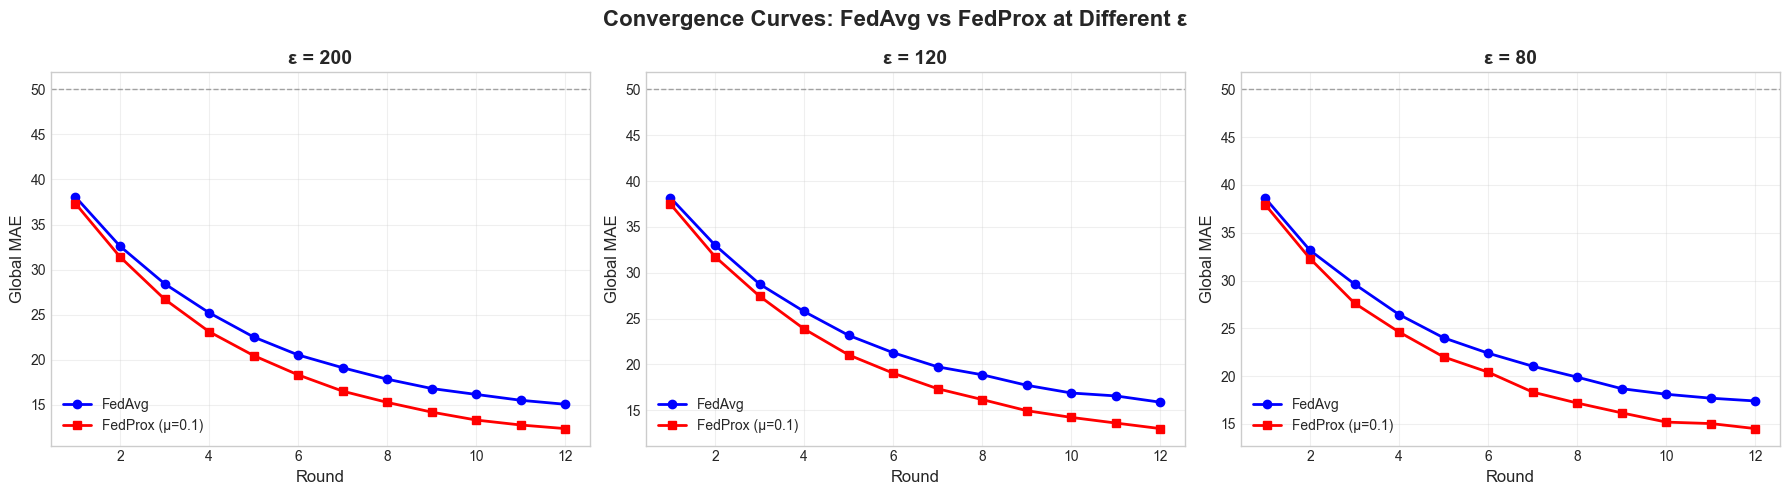


Saved: ..\experiments\outputs\privacy_fedprox_eval\convergence_comparison.png


In [16]:
# Convergence curves - show 3 representative ε values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Select 3 representative epsilons: high, mid, low
eps_to_plot = [200, 120, 80]

for i, eps in enumerate(eps_to_plot):
    ax = axes[i]
    
    fa_name = f'FedAvg_{eps}'
    fp_name = f'FedProx_{eps}'
    
    if fa_name in round_data:
        df = round_data[fa_name]
        ax.plot(df['round_id'], df['global_mae'], 'b-o', 
                label='FedAvg', linewidth=2, markersize=6)
    
    if fp_name in round_data:
        df = round_data[fp_name]
        ax.plot(df['round_id'], df['global_mae'], 'r-s', 
                label=f'FedProx (μ={FEDPROX_MU})', linewidth=2, markersize=6)
    
    ax.axhline(y=MAE_THRESHOLD, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xlabel('Round', fontsize=12)
    ax.set_ylabel('Global MAE', fontsize=12)
    ax.set_title(f'ε = {eps}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

fig.suptitle('Convergence Curves: FedAvg vs FedProx at Different ε', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'convergence_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {OUTPUT_DIR / 'convergence_comparison.png'}")

## 7. Verdict & Recommendations

In [17]:
print("=" * 80)
print("PRIVACY-FEDPROX EVALUATION VERDICT")
print("=" * 80)

print("\n[EXPERIMENTAL SETUP]")
print(f"  • Epsilon grid: {EPSILONS}")
print(f"  • FedProx μ: {FEDPROX_MU}")
print("  • Clients: 5")
print("  • Data profile: non_iid_hard (single-source heterogeneity)")
print("  • Partitioning: uniform (Dirichlet BLOCKED)")
print("  • Rounds: 12, Local epochs: 2, Participation: 80%")

print("\n[STABILITY THRESHOLDS]")
print(f"  • MAE threshold: {MAE_THRESHOLD}")
print(f"  • RMSE threshold: {RMSE_THRESHOLD}")

print("\n[RESULTS SUMMARY]")
print("-" * 80)
if len(df_summary) > 0:
    cols = ['name', 'algorithm', 'epsilon', 'mu', 'final_mae', 'final_rmse', 'stable']
    print(df_summary[cols].to_string(index=False))

print("\n[FEDPROX vs FEDAVG by ε]")
print("-" * 80)
if len(df_improvements) > 0:
    for _, row in df_improvements.iterrows():
        mae_status = "BETTER" if row['mae_improvement_pct'] > 0 else "WORSE"
        stability_status = ""
        if row['fedprox_stable'] and not row['fedavg_stable']:
            stability_status = " [FedProx STABLE, FedAvg UNSTABLE]"
        elif row['fedavg_stable'] and not row['fedprox_stable']:
            stability_status = " [FedAvg STABLE, FedProx UNSTABLE]"
        elif not row['fedavg_stable'] and not row['fedprox_stable']:
            stability_status = " [BOTH UNSTABLE]"
        
        print(f"  ε={int(row['epsilon'])}: FedProx {mae_status} by {abs(row['mae_improvement_pct']):.1f}%{stability_status}")
        print(f"           FedAvg: MAE={row['fedavg_mae']:.2f}, RMSE={row['fedavg_rmse']:.2f}")
        print(f"           FedProx: MAE={row['fedprox_mae']:.2f}, RMSE={row['fedprox_rmse']:.2f}")

# Collapse threshold analysis
print("\n[COLLAPSE THRESHOLD SHIFT]")
print("-" * 80)

fedavg_stable_eps = df_improvements[df_improvements['fedavg_stable']]['epsilon'].tolist()
fedprox_stable_eps = df_improvements[df_improvements['fedprox_stable']]['epsilon'].tolist()

fedavg_min = min(fedavg_stable_eps) if fedavg_stable_eps else None
fedprox_min = min(fedprox_stable_eps) if fedprox_stable_eps else None

print(f"  FedAvg stable at ε: {fedavg_stable_eps if fedavg_stable_eps else 'NONE'}")
print(f"  FedProx stable at ε: {fedprox_stable_eps if fedprox_stable_eps else 'NONE'}")

if fedavg_min and fedprox_min:
    shift = fedavg_min - fedprox_min
    print(f"\n  FedAvg min stable ε: {fedavg_min}")
    print(f"  FedProx min stable ε: {fedprox_min}")
    if shift > 0:
        print(f"\n  >>> FedProx EXTENDS stable privacy range by Δε = {shift}")
        print(f"      (Can use {shift} smaller ε while staying stable)")
    elif shift < 0:
        print(f"\n  >>> FedAvg more robust by Δε = {-shift}")
    else:
        print(f"\n  >>> Same collapse threshold")

# Final verdict
print("\n[VERDICT]")
print("-" * 80)

fedprox_wins = sum(df_improvements['fedprox_better']) if len(df_improvements) > 0 else 0
total_comparisons = len(df_improvements)
fedprox_stable_count = sum(df_improvements['fedprox_stable'])
fedavg_stable_count = sum(df_improvements['fedavg_stable'])

print(f"  MAE: FedProx wins {fedprox_wins}/{total_comparisons} comparisons")
print(f"  Stability: FedProx {fedprox_stable_count}/{total_comparisons}, FedAvg {fedavg_stable_count}/{total_comparisons}")

if fedprox_stable_count > fedavg_stable_count:
    print("\n  RECOMMENDATION: FedProx provides BETTER STABILITY at strong privacy.")
elif fedprox_wins == total_comparisons:
    print("\n  RECOMMENDATION: FedProx consistently outperforms FedAvg.")
elif fedprox_wins > total_comparisons / 2:
    print("\n  RECOMMENDATION: FedProx generally better, especially at lower ε.")
else:
    print("\n  RECOMMENDATION: Consider tuning μ or using FedAvg for this setup.")

# Save report
report = {
    'timestamp': datetime.now().isoformat(),
    'setup': {
        'epsilon_grid': EPSILONS,
        'fedprox_mu': FEDPROX_MU,
        'num_clients': 5,
        'local_epochs': 2,
        'num_rounds': 12,
        'data_profile': 'non_iid_hard',
        'heterogeneity_mode': 'uniform',
        'mae_threshold': MAE_THRESHOLD,
        'rmse_threshold': RMSE_THRESHOLD,
    },
    'experiments': df_summary.to_dict(orient='records'),
    'improvements': df_improvements.to_dict(orient='records') if len(df_improvements) > 0 else [],
    'collapse_thresholds': {
        'fedavg_min_stable_eps': fedavg_min,
        'fedprox_min_stable_eps': fedprox_min,
        'threshold_shift': (fedavg_min - fedprox_min) if (fedavg_min and fedprox_min) else None,
    },
    'fedprox_wins': int(fedprox_wins),
    'total_comparisons': int(total_comparisons),
}

with open(OUTPUT_DIR / 'evaluation_report.json', 'w') as f:
    json.dump(report, f, indent=2, default=str)

print(f"\nSaved: {OUTPUT_DIR / 'evaluation_report.json'}")

PRIVACY-FEDPROX EVALUATION VERDICT

[EXPERIMENTAL SETUP]
  • Epsilon grid: [200, 150, 120, 100, 80]
  • FedProx μ: 0.1
  • Clients: 5
  • Data profile: non_iid_hard (single-source heterogeneity)
  • Partitioning: uniform (Dirichlet BLOCKED)
  • Rounds: 12, Local epochs: 2, Participation: 80%

[STABILITY THRESHOLDS]
  • MAE threshold: 50.0
  • RMSE threshold: 80.0

[RESULTS SUMMARY]
--------------------------------------------------------------------------------
       name algorithm  epsilon  mu  final_mae  final_rmse  stable
 FedAvg_200    FEDAVG    200.0 0.0  29.101835   42.322089    True
 FedAvg_150    FEDAVG    150.0 0.0  39.825104   65.660426    True
 FedAvg_120    FEDAVG    120.0 0.0  65.575592   98.457186   False
 FedAvg_100    FEDAVG    100.0 0.0  82.755272  140.453159   False
  FedAvg_80    FEDAVG     80.0 0.0 142.439041  226.883634   False
FedProx_200   FEDPROX    200.0 0.1  32.585373   49.192374    True
FedProx_150   FEDPROX    150.0 0.1  53.122574   77.184682   False
FedPro